In [316]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [233]:
BATCH_SIZE = 2

In [234]:
df = pd.read_csv('datasets/CICIDS_2017_portscan.csv')

In [235]:
df.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [236]:
def clean_columns(dataframe):
    for column in dataframe:
        dataframe.rename(columns = {column : column.lower().lstrip().replace(" ", "_")}, inplace = 1)
    return dataframe

In [237]:
df = clean_columns(df)

In [238]:
df.columns

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes/s', 'flow_packets/s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags',
       'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_length',
       'bwd_header_length', 'fwd_packets/s', 'bwd_packets/s',
       'min_packet_length', 'max_packet_length', 'packet_length_mean',
       'packet_length_std', 'packet_length_variance', 'fin_flag_count',
       'syn_flag_co

In [239]:
df['label'].unique()

array(['BENIGN', 'PortScan'], dtype=object)

<AxesSubplot:xlabel='label'>

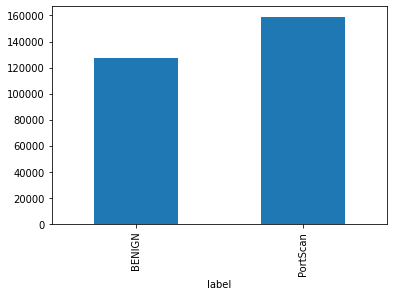

In [240]:
df.groupby(['label'])['label'].count().plot(kind='bar')

In [241]:
df.describe()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
count,286467.000000,2.864670e+05,286467.000000,286467.000000,286467.000000,2.864670e+05,286467.000000,286467.000000,286467.000000,286467.000000,...,286467.000000,286467.000000,2.864670e+05,2.864670e+05,2.864670e+05,2.864670e+05,2.864670e+05,2.864670e+05,2.864670e+05,2.864670e+05
mean,8044.876324,5.379331e+06,3.473283,3.520500,233.407667,2.707247e+03,81.033369,10.352013,24.138688,24.590994,...,1.728618,29.075328,3.409213e+04,2.294987e+04,7.785722e+04,2.171380e+04,1.602973e+06,6.120390e+04,1.647188e+06,1.536286e+06
std,15378.583442,2.192364e+07,19.515131,28.288916,1865.523600,5.097783e+04,327.768035,24.237795,78.381542,117.218043,...,14.897361,8.014607,4.659319e+05,2.623049e+05,7.342606e+05,4.223145e+05,8.682334e+06,1.217016e+06,8.882728e+06,8.561545e+06
min,0.000000,-1.300000e+01,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,80.000000,4.400000e+01,1.000000,1.000000,0.000000,6.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1110.000000,6.500000e+01,1.000000,1.000000,2.000000,6.000000e+00,2.000000,2.000000,2.000000,0.000000,...,0.000000,24.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,6881.000000,2.380600e+04,2.000000,2.000000,62.000000,1.150000e+02,37.000000,6.000000,34.000000,0.000000,...,1.000000,40.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,65389.000000,1.199999e+08,3119.000000,3635.000000,232349.000000,7.150819e+06,13929.000000,1472.000000,3412.938776,3541.466551,...,2056.000000,60.000000,1.100000e+08,7.050000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.050000e+07,1.200000e+08,1.200000e+08


In [242]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286467 entries, 0 to 286466
Data columns (total 79 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   destination_port             286467 non-null  int64  
 1   flow_duration                286467 non-null  int64  
 2   total_fwd_packets            286467 non-null  int64  
 3   total_backward_packets       286467 non-null  int64  
 4   total_length_of_fwd_packets  286467 non-null  int64  
 5   total_length_of_bwd_packets  286467 non-null  int64  
 6   fwd_packet_length_max        286467 non-null  int64  
 7   fwd_packet_length_min        286467 non-null  int64  
 8   fwd_packet_length_mean       286467 non-null  float64
 9   fwd_packet_length_std        286467 non-null  float64
 10  bwd_packet_length_max        286467 non-null  int64  
 11  bwd_packet_length_min        286467 non-null  int64  
 12  bwd_packet_length_mean       286467 non-null  float64
 13 

In [243]:
df.drop_duplicates(inplace=True)

In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214114 entries, 0 to 286466
Data columns (total 79 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   destination_port             214114 non-null  int64  
 1   flow_duration                214114 non-null  int64  
 2   total_fwd_packets            214114 non-null  int64  
 3   total_backward_packets       214114 non-null  int64  
 4   total_length_of_fwd_packets  214114 non-null  int64  
 5   total_length_of_bwd_packets  214114 non-null  int64  
 6   fwd_packet_length_max        214114 non-null  int64  
 7   fwd_packet_length_min        214114 non-null  int64  
 8   fwd_packet_length_mean       214114 non-null  float64
 9   fwd_packet_length_std        214114 non-null  float64
 10  bwd_packet_length_max        214114 non-null  int64  
 11  bwd_packet_length_min        214114 non-null  int64  
 12  bwd_packet_length_mean       214114 non-null  float64
 13 

In [245]:
df.columns[df.isna().any()].tolist()

['flow_bytes/s']

In [246]:
df = df.fillna(method='bfill')

In [247]:
df['label'] = df['label'].apply(lambda x: 0 if x=='BENIGN' else 1)
df['label'].unique()

array([0, 1], dtype=int64)

In [248]:
df['label'].head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [249]:
df.groupby(['label'])['label'].count()

label
0    123295
1     90819
Name: label, dtype: int64

In [250]:
y = df['label']
X = df.drop(columns=['label'])

In [251]:
X.head()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,24,32,0.0,0.0,0,0,0.0,0.0,0,0
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,24,32,0.0,0.0,0,0,0.0,0.0,0,0
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,24,32,0.0,0.0,0,0,0.0,0.0,0,0
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0


In [252]:
X[np.isinf(X).all(1)]

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min


In [253]:
# Create correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
to_drop

['total_backward_packets',
 'total_length_of_bwd_packets',
 'fwd_packet_length_std',
 'bwd_packet_length_mean',
 'bwd_packet_length_std',
 'flow_iat_std',
 'flow_iat_max',
 'fwd_iat_total',
 'fwd_iat_mean',
 'fwd_iat_max',
 'fwd_iat_min',
 'bwd_iat_total',
 'bwd_iat_mean',
 'bwd_iat_max',
 'bwd_iat_min',
 'fwd_header_length',
 'bwd_header_length',
 'fwd_packets/s',
 'max_packet_length',
 'packet_length_mean',
 'packet_length_std',
 'packet_length_variance',
 'syn_flag_count',
 'ece_flag_count',
 'average_packet_size',
 'avg_fwd_segment_size',
 'avg_bwd_segment_size',
 'fwd_header_length.1',
 'subflow_fwd_packets',
 'subflow_fwd_bytes',
 'subflow_bwd_packets',
 'subflow_bwd_bytes',
 'active_min',
 'idle_mean',
 'idle_max',
 'idle_min']

In [254]:
X.drop(to_drop, axis=1, inplace=True)

In [255]:
X.head()

,destination_port,flow_duration,total_fwd_packets,total_length_of_fwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,bwd_packet_length_max,bwd_packet_length_min,flow_bytes/s,...,bwd_avg_packets/bulk,bwd_avg_bulk_rate,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,idle_std
0,22,1266342,41,2664,456,0,64.975610,976,0,7595.104640,...,0,0,29200,243,24,32,0.0,0.0,0,0.0
1,22,1319353,41,2664,456,0,64.975610,976,0,7289.936810,...,0,0,29200,243,24,32,0.0,0.0,0,0.0
2,22,160,1,0,0,0,0.000000,0,0,0.000000,...,0,0,290,243,0,32,0.0,0.0,0,0.0
3,22,1303488,41,2728,456,0,66.536585,976,0,7182.267884,...,0,0,29200,243,24,32,0.0,0.0,0,0.0
4,35396,77,1,0,0,0,0.000000,0,0,0.000000,...,0,0,243,290,0,32,0.0,0.0,0,0.0


In [256]:
X_tensor = tf.convert_to_tensor(X)
y_tensor = tf.convert_to_tensor(y)

In [318]:
# TODO
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    x_train_df = df.iloc[train_idx]
    x_test_df = df.iloc[test_idx]

In [313]:
model = models.Sequential()
model.add(layers.Conv1D(32, (1), activation='relu', input_shape=(42, 1)))
model.add(layers.MaxPooling1D((1)))
model.add(layers.Conv1D(32, (1), activation='relu'))
model.add(layers.MaxPooling1D((1)))
model.add(layers.Conv1D(32, (1), activation='relu'))
model.add(layers.GRU(64, activation='relu', return_sequences=True))
model.add(layers.GRU(64, activation='relu'))
model.add(layers.Dense(2))

In [314]:
model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_62 (Conv1D)          (None, 42, 32)            64        
                                                                 
 max_pooling1d_41 (MaxPoolin  (None, 42, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_63 (Conv1D)          (None, 42, 32)            1056      
                                                                 
 max_pooling1d_42 (MaxPoolin  (None, 42, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_64 (Conv1D)          (None, 42, 32)            1056      
                                                                 
 gru_16 (GRU)                (None, 42, 64)          

In [315]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_tensor, y_tensor, epochs=5, batch_size=1)

Epoch 1/5
 40869/214114 [====>.........................] - ETA: 38:31 - loss: nan - accuracy: 0.5731

KeyboardInterrupt: 